# Project rent burden for 2020-2021 school year

This notebook estimates the change in number of on-campus grad students who will be rent burdened during the upcoming 2020-2021 school year following UCSD's proposed rent increases. This analysis makes the simplifying assumption that all students currently living in an on-campus unit will still be living in that unit next year. 

This analyis was performed well in advance of the COVID-19 shutdowns on campus and wider society, and as I document this notebook now on March 14th 2020, housing situation changes related to COVID-19 cannot be predicted or anticipated. Future versions of this analysis may be conducted to reflect any major changes in UCSD housing policy.

**Note**: This notebook originally used the uncensored data. There may be slight differences when this analysis is reproduced with the public data. See the notebook in `data/` for more information on what was censored from the public release.

In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objs as go
from scipy.stats import mannwhitneyu

Check that pandas version is $\geq$ 1.0.

In [2]:
pd.__version__

'1.0.1'

Check that plotly version is 4.5.0

In [5]:
import plotly
plotly.__version__

'4.5.0'

# Load survey data

This file is the raw survey data from Google Forms with the column names altered to be shorter.

In [7]:
df = pd.read_csv("2020_housingsurvey/clean_data/2020_15.50_short-cols.tsv", sep = '\t')
df.head()

,Unnamed: 0,start_date,end_date,resp_type,ip,progress,duration,finished,rec_date,resp_id,...,n_dependents,has_healthcare,dependent_has_healthcare_CAT,depdendent_has_healthcare_TXT,expenses_CAT,expenses_TXT,expenses_cost_month,comments,parent_topics,topics
0,1,2020-02-05 16:42:04,2020-02-05 16:45:55,Survey Preview,NaN,100,230,True,2020-02-05 16:45:55.453000,R_2ir9mTnzPwy5Dnb,...,1,NaN,NaN,NaN,NaN,NaN,NaN,You are a goddess,NaN,Unknown
1,2,2020-02-05 18:27:44,2020-02-05 19:10:56,Survey Preview,NaN,100,2591,True,2020-02-05 19:10:56.668000,R_10TRlQ4wnfjELpB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown
2,3,2020-02-05 19:09:12,2020-02-05 19:12:38,Survey Preview,NaN,100,205,True,2020-02-05 19:12:38.293000,R_V3IqukjLVB20BLX,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown
3,4,2020-02-05 19:09:36,2020-02-05 19:12:42,Survey Preview,NaN,100,186,True,2020-02-05 19:12:43.306000,R_Zt6ip9HGmdFeHrX,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown
4,5,2020-02-05 19:10:32,2020-02-05 19:12:51,Survey Preview,NaN,100,138,True,2020-02-05 19:12:51.718000,R_1jMJreLskBbuWpc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Clean dollar amounts in rent column

This function cleans up the low-hanging fruit in reported dollar amounts. Values that could not be cleaned (converted to integers automatically) will eventually be excluded. I have written this function to print out these values so at the very least these reported experiences will be documented somewhere. "Homeless" is not an integer.

In [8]:
def clean_dollars(x):
    val = str(x)
    try:
        return int(val.split()[0].replace("$","").replace(",","").replace("~","").split('.')[0])
    except (TypeError, ValueError):
        print(val)
        return val

In [9]:
df["rent_month"] = df["rent_month"].apply(clean_dollars)

Homeless
I live with family because I can not afford rent
850-870
$pence 1074
I have a mortgate, and two kids in college I pay both their rents too $5000
Right now 600 but I will soon have to pay 1000
personal: $1150; whole house: $3950


# Clean dollar amounts in income column

In [10]:
df["grad_prog_comp"] = df["grad_prog_comp"].apply(clean_dollars)

1600/month
Around $28000
None
not enough
-
Depends.  about $25,000 for 2 years fellowship, TA wages for other years
32’000
30k last fiscal year, according to W2
Around 21,000
￥1，000
approximately $28,800
nan
first year: $4,000 in stipend/award, $7,000-14,000 employment salary range
Program costs and variable employment
32K
~ $21,000
?
18000-24000
nan
$30K (pre-tax income)
Only tuition remission 
Allegedly $33,000
$26,000-27,000
nan
$ 13368
Not guaranteed
&lt;20,000
about $21,000 before tax but after mandatory fees


# Check both income and rent are integers

In [11]:
def are_income_rent_ints(row):
    return type(row["grad_prog_comp"]) == int and type(row["rent_month"]) == int

In [12]:
print(df.shape)

df = df[df.apply(are_income_rent_ints, axis = 1)]

df.shape

(971, 65)


(936, 65)

After cleaning and converting relevant dollar amounts to integers, 936 observations remain.

# Drop rows where `grad_prog_comp` is 0

Graduate program compensation is used as income. Therefore this column cannot be zero for rent burden calculations.

In [13]:
print(df.shape)

df = df[df["grad_prog_comp"] > 0]

df.shape

(936, 65)


(889, 65)

# Calculate rent fraction of income

In [14]:
df["rent_burden"] = (df["rent_month"] * 12) / df["grad_prog_comp"]

# Remove rent burden values > 1.0

These are assumed to be erroneous observations. Some respondents very likely included the rent for their entire unit, not just the room they pay for. 

In [15]:
print(df.shape)

df = df[df["rent_burden"] < 1.0]

df.shape

(889, 66)


(835, 66)

# Function: Violin w/rent burden line

Plot the distribution of rent burdens from the survey.

In [16]:
def plot_rent_burden(rent_burdens):
    fig = go.Figure()
    fig.add_trace(
        go.Violin(
            y = rent_burdens,
            name = "Rent Burden",
            box_visible = True,
            meanline_visible = True
        )
    )
    fig.update_layout(template='plotly_white')
    fig.show(renderer="png")

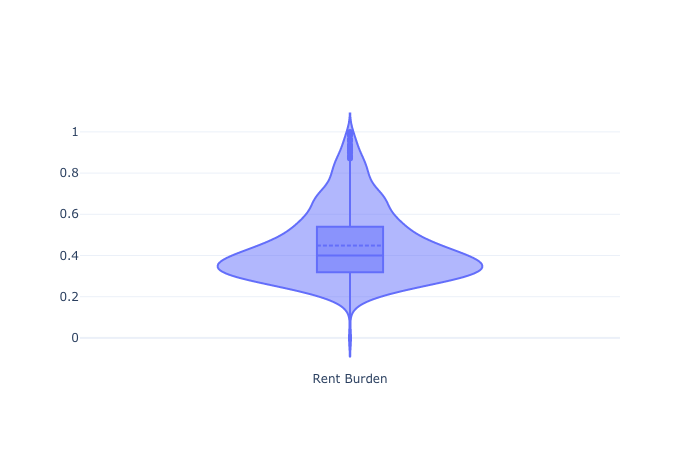

In [17]:
plot_rent_burden(df["rent_burden"])

# Visualize rent burden for on campus

Visualize just rent burdens for on campus grad students.

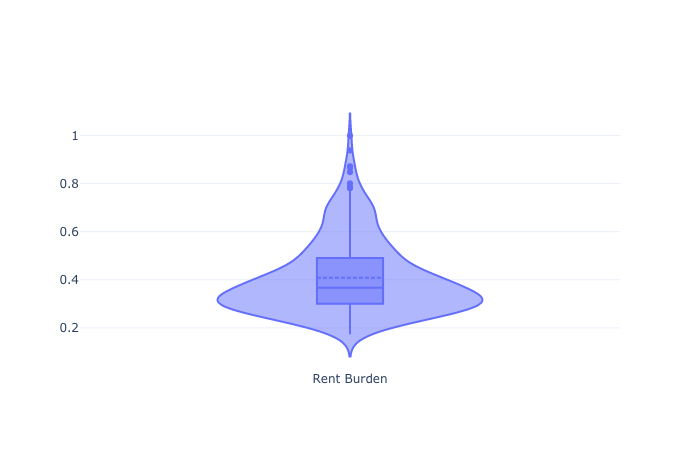

In [15]:
on_campus_categories = ["On-campus (lease/rent)", "On-campus (sublet)"]

plot_rent_burden(
    df[df["on_campus"].isin(on_campus_categories)]["rent_burden"]
)

# Construct a dataframe of current and projected rents

This uses Petia's data [here](https://docs.google.com/spreadsheets/d/1r1sWVa-RuEmTx7nQN08XOEJHT4Uqi7thAY3qwDDQ0Lg/edit#gid=0). Rent amounts are the amount *per room*, i.e., 2bed rates are divided by 2.

In [18]:
housing_df = pd.DataFrame([
    ("coastst", "old", 21, 794, 818),
    ("coast1bd", "old", 54, 1075, 1108),
    ("coast2bd", "old", 62, 1502/2.0, 1547/2.0),
    ("cm1bd", "old", 9, 1103, 1136),
    ("cm2bd", "old", 364, 1217/2.0, 1254/2.0),
    ("cm3bd", "old", 27, 1412/3.0, 1454/3.0),
    ("sm2bd", "old", 380, 1409/2.0, 1451/2.0),
    ("oms2bd", "old", 806, 1307/2.0, 1346/2.0),
    ("mnst", "old", 853, 849, 900),
    ("mn1bd", "old", 44, 1191, 1250),
    ("mn2bd", "old", 332, 1666/2.0, 1750/2.0),
    ("mn3bd", "old", 120, 2470/3.0, 2593/3.0),
    ("ne1bd", "new", 199, np.nan, 1302),
    ("ne2b1b", "new", 536, np.nan, 1851/2.0),
    ("ne3b2b", "new", 324, np.nan, 2850/3.0),
    ("ne4b2b", "new", 304, np.nan, 3600/4.0),
    ("nw2b2b", "new", 76, np.nan, 2080/2.0),
    ("nw2b1b", "new", 228, np.nan, 1930/2.0),
    ("nw4b2b", "new", 528, np.nan, 3760/4.0),
    ("nw6b3b", "new", 42, np.nan, 5490/6.0)
])
housing_df.columns = ["unit_type", "age", "n_beds", "rent_19-20", "rent_20-21"]
housing_df.head()

,unit_type,age,n_beds,rent_19-20,rent_20-21
0,coastst,old,21,794.0,818.0
1,coast1bd,old,54,1075.0,1108.0
2,coast2bd,old,62,751.0,773.5
3,cm1bd,old,9,1103.0,1136.0
4,cm2bd,old,364,608.5,627.0


# Function: Convert row in survey to `unit_type` in `housing_df`

In [19]:
building_map = {
    "Coast": "coast",
    "Mesa": "cm",
    "Mesa Nueva": "mn",
    "One Miramar St.": "oms"
}

size_map = {
    "Studio": "st",
    "1 bedroom": "1bd",
    "2 bedrooms": "2bd",
    "3 bedrooms": "3bd"
}

def get_unit_type(row):
    try:
        building = building_map[row["house_devel"]]
    except KeyError:
        return np.nan
    
    try:
        size = size_map[row["n_beds"]]
    except KeyError:
        return np.nan
    
    return building+size

In [21]:
df_on_campus = df[df["on_campus"].isin(["On-campus (lease/rent)", "On-campus (sublet)"])]

print(df_on_campus.shape)

#df_on_campus["unit_type"] = df_on_campus.apply(get_unit_type, axis = 1).dropna(subset = ["unit_type"])
df_on_campus["unit_type"] = df_on_campus.apply(get_unit_type, axis = 1)
df_on_campus = df_on_campus.dropna(subset = ["unit_type"])

df_on_campus.shape

(358, 66)


/Users/alexwenzel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(332, 67)

# Convert central mesa studio to 1 bd

In [22]:
df_on_campus["unit_type"] = df_on_campus["unit_type"].replace("cmst", "cm1bd")

# Map new rents

Here the current rents from the surveys are projected to next year using the proposed increases.

In [23]:
new_rent_map = housing_df["rent_20-21"]
new_rent_map.index = housing_df["unit_type"]
new_rent_map.head()

unit_type
coastst      818.0
coast1bd    1108.0
coast2bd     773.5
cm1bd       1136.0
cm2bd        627.0
Name: rent_20-21, dtype: float64

In [24]:
df_on_campus["new_rent_month"] = df_on_campus.apply(lambda row: new_rent_map[row["unit_type"]], axis = 1)

# Calculate new rent burden

In [22]:
df_on_campus["new_rent_burden"] = (df_on_campus["new_rent_month"] * 12) / df_on_campus["grad_prog_comp"]

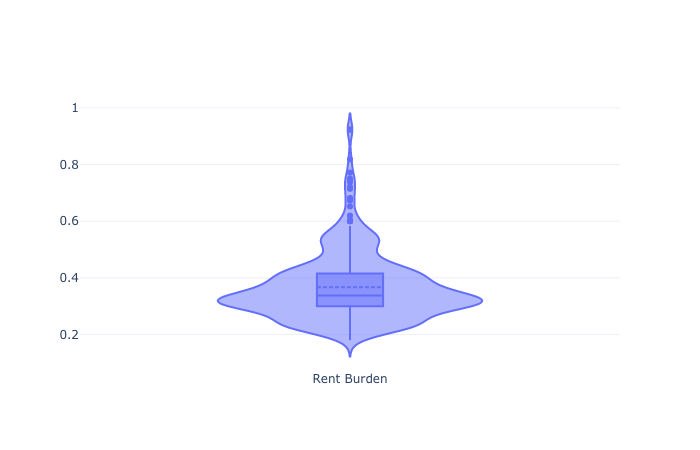

In [23]:
plot_rent_burden(
    df_on_campus["new_rent_burden"]
)

# Final df before/after

In [24]:
final_oc = df_on_campus[
    ["grad_prog_comp", "rent_month", "rent_burden", "unit_type", "new_rent_month", "new_rent_burden"]
]

In [25]:
final_oc.head()

,grad_prog_comp,rent_month,rent_burden,unit_type,new_rent_month,new_rent_burden
1,20000,846,0.5076,mnst,900.000000,0.54
2,33000,670,0.243636,cm2bd,627.000000,0.228
4,30000,849,0.3396,mnst,900.000000,0.36
5,34000,653,0.230471,oms2bd,673.000000,0.237529
8,34000,850,0.3,mn3bd,864.333333,0.305059


# Combined violin plot

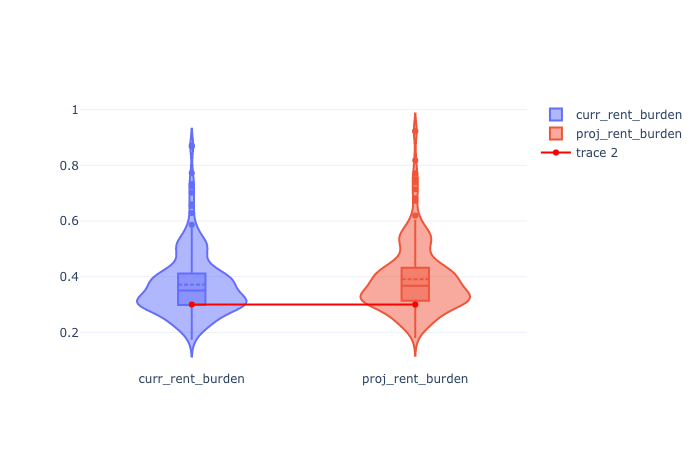

In [32]:
fig = go.Figure()

greater = final_oc[final_oc["new_rent_month"] > final_oc["rent_month"]]

curr_rent_burden = list(greater["rent_burden"])
proj_rent_burden = list(greater["new_rent_burden"])

for pair in [("curr_rent_burden", curr_rent_burden), ("proj_rent_burden", proj_rent_burden)]:
    fig.add_trace(
        go.Violin(
            x = [pair[0]]*len(pair[1]),
            y = pair[1],
            name = pair[0],
            box_visible = True,
            meanline_visible = True
        )
    )
    
fig.add_trace(
    go.Scatter(
        x = ["curr_rent_burden", "proj_rent_burden"],
        y = [0.3, 0.3],
        line = dict(
            color = 'red'
        )
    )
)

fig.update_layout(template = 'plotly_white')
fig.show(renderer="png")

In [30]:
greater[greater["rent_burden"]>0.3].shape[0]/greater.shape[0]

0.6954545454545454

In [31]:
greater[greater["new_rent_burden"]>0.3].shape[0]/greater.shape[0]

0.8181818181818182

In [33]:
greater.shape

(220, 6)

In [34]:
set(greater["unit_type"])

{'cm1bd',
 'cm2bd',
 'coast1bd',
 'coast2bd',
 'coastst',
 'mn1bd',
 'mn2bd',
 'mn3bd',
 'mnst',
 'oms2bd'}